# deepfake images detection with vgg16

In [1]:
# import 
import os

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
base_path = './140K-data/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255., validation_split = 0.99)
batch_size = 64
image_size = (224,224)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    image_size,
    batch_size=batch_size,
    class_mode='binary',
    #subset = 'training'
)

valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    image_size,
    batch_size=batch_size,
    class_mode='binary',
    #subset = 'training'
)

test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    image_size,
    batch_size=1,
    shuffle=False,
    class_mode='binary',
    #subset = 'training'
)


Found 100000 images belonging to 2 classes.
Found 10576 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
#vgg_model = VGG16(include_top=False, input_shape = (224,224,3))

vgg_16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None', classes=2)
vgg_16.trainable = False

vgg_model = Sequential()
vgg_model.add(vgg_16)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu', name='dense_feature'))
vgg_model.add(Dense(1, activation="sigmoid"))

vgg_model.build(input_shape=(224, 224, 3))
vgg_model.summary()


#custom_vgg_model = Model(vgg_model.input, dense2)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_feature (Dense)        (None, 256)               6422784   
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#custom_vgg_model.summary()

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.10/install/bin/python3.8 -m pip install --upgrade pip' command.


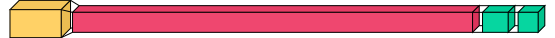

In [10]:
!pip install visualkeras
import visualkeras

#model = ...

visualkeras.layered_view(vgg_model).show() # display using your system viewer
visualkeras.layered_view(vgg_model, to_file='output.png') # write to disk
visualkeras.layered_view(vgg_model, to_file='output.png').show() # write and show

visualkeras.layered_view(vgg_model)

In [11]:
# compile
vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002), 
    metrics=['acc']
)

In [12]:
train_steps = 10000//batch_size
valid_steps = 2000//batch_size

# fit
history = vgg_model.fit_generator(
    train_flow,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
156/156 [==============================] - 212s 1s/step - loss: 0.5932 - acc: 0.6919 - val_loss: 0.4302 - val_acc: 0.8125
Epoch 2/10
156/156 [==============================] - 188s 1s/step - loss: 0.4554 - acc: 0.7854 - val_loss: 0.3752 - val_acc: 0.8427
Epoch 3/10
156/156 [==============================] - 181s 1s/step - loss: 0.4067 - acc: 0.8163 - val_loss: 0.5267 - val_acc: 0.7434
Epoch 4/10
156/156 [==============================] - 163s 1s/step - loss: 0.3768 - acc: 0.8322 - val_loss: 0.4011 - val_acc: 0.8256
Epoch 5/10
156/156 [==============================] - 142s 909ms/step - loss: 0.3549 - acc: 0.8487 - val_loss: 0.4824 - val_acc: 0.7782
Epoch 6/10
156/156 [==============================] - 132s 846ms/step - loss: 0.3470 - acc: 0.8520 - val_loss: 0.5696 - val_acc: 0.7238
Epoch 7/10
156/156 [==============================] - 122s 784ms/step - loss: 0.3267 - acc: 0.8595 - val_loss: 0.4105 - 

In [14]:
vgg_model.save('vgg16.h5')

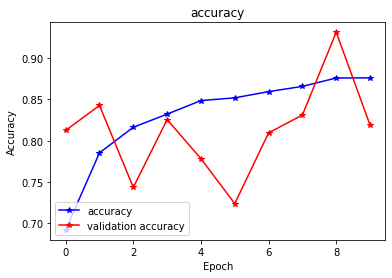

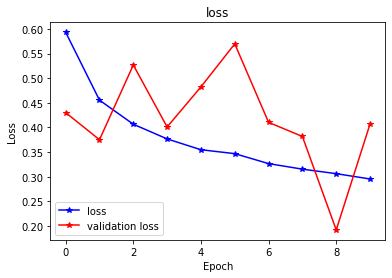

In [15]:
plt.plot(history.history['acc'], '*-b', label = 'accuracy')
plt.plot(history.history['val_acc'], '*-r', label = 'validation accuracy')
plt.title('accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

#Loss
plt.plot(history.history['loss'], '*-b', label = "loss")
plt.plot(history.history['val_loss'], '*-r', label = "validation loss")
plt.title('loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split = 0.1)
testpath = './140K-data/real_vs_fake/real-vs-fake/'

eval_generator = test_datagen.flow_from_directory(testpath + 'test/',
                                                  target_size=image_size,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  seed=42,
                                                  class_mode="binary",
                                                 # subset = 'training'
                                                 )
eval_generator.reset()
print(len(eval_generator))
x = vgg_model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 20000 images belonging to 2 classes.
20000
20000/20000 [==============================] - 287s 14ms/step - loss: 0.3241 - acc: 0.8611
Test loss: 0.3240855038166046
Test accuracy: 0.861050009727478


In [21]:
y_pred = vgg_model.predict(test_flow)
y_test = test_flow.classes

In [23]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.94257265
AP Score: 0.9419998949909404

              precision    recall  f1-score   support

           0       0.91      0.80      0.85     10000
           1       0.82      0.92      0.87     10000

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000



Found 200 images belonging to 2 classes.
200/200 [==============================] - 1s 3ms/step
(200, 256)
(200, 2)
100
100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


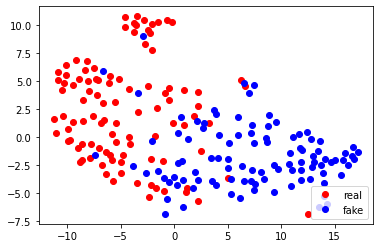

In [35]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=vgg_model.input,
                                        outputs=vgg_model.get_layer('dense_feature').output)

newDataGen = ImageDataGenerator(rescale=1. / 255, validation_split = 0.01)

tsne_eval_generator = newDataGen.flow_from_directory(base_path+'test/',target_size=image_size,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary", subset = 'validation')

    
pred = intermediate_layer_model.predict_generator(tsne_eval_generator,200,verbose=1)
print(pred.shape)
features = TSNE(n_components=2).fit_transform(pred)
print(features.shape)

x1,x2,y1,y2 = [],[],[],[]
cls = tsne_eval_generator.classes
sumA = 0 
sumB = 0
for i in cls:
    if i ==0:
        sumA+=1
    else:
        sumB+=1
        
print(sumA)
print(sumB)
print(cls)
for i in range(len(features)):
    if cls[i] == 0: 
        x1.append(features[i, 0])
        y1.append(features[i, 1])    
    else:
        x2.append(features[i, 0])
        y2.append(features[i, 1])

plt.figure()
plt.plot(x1, y1, 'ro', label="real")
plt.plot(x2, y2, 'bo', label="fake")
plt.legend(loc='lower right')